# Neural Network Classifier for Particle Physics

In this exercise, we'll build a PyTorch binary classifier DNN, and apply this DNN to separating a Higgs Boson signal from a background process.

The signal process is a Higgs Boson decaying to two leptons among other stuff. The background process is a pair of top quarks decaying to a very similar final state, two leptons plus other particles, that look on a first glance essentially the same in the detector.

Each dataset contains 26 features related to the particles detected in each case.

In [ ]:
import h5py
import pandas as pd
import numpy as np
import torch

## Importing Data

The data is stored in `h5` format which is the industry standard for storing numpy arrays in machine learning contexts.

The file contains two datasets, `Signal` and `Background`. Each dataset is an array of shape N x 26, where N is the number of separate proton-proton collisions (we call these "events") and 26 refers to the number of features.

We can load both datasets as pandas dataframes.

In [ ]:
# Load file
file = h5py.File("WW_vs_TT_dataset.h5")

# Extract data
df_signal       = pd.DataFrame(file['Signal'][:])
df_background   = pd.DataFrame(file['Background'][:])

## Data Visualisation

As we stated before, it's useful to understand the input parameters and compare them between the different classes.

The following function can be used to draw histograms of the two classes.

In [ ]:
import matplotlib.pyplot as plt
def compare_distributions(signal_data, background_data, variable_name):
    plt.figure(figsize=(10, 6),dpi=100)
    plt.hist(signal_data[variable_name], bins=40,  histtype='step', label='Signal', density=True)
    plt.hist(background_data[variable_name], bins=40, histtype='step', label='Background', density=True)
    plt.xlabel(variable_name)
    plt.ylabel('Density')
    plt.title(f'Distribution of {variable_name}')
    plt.legend()
    plt.show()

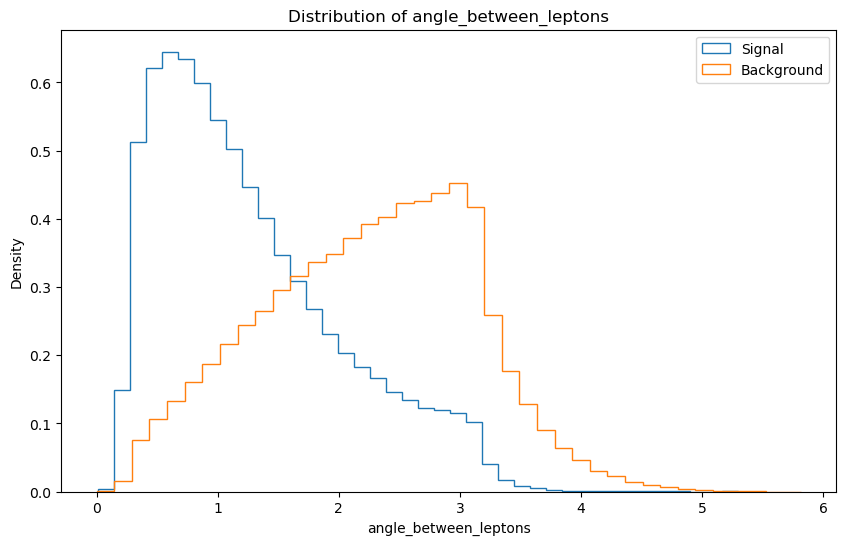

In [ ]:
compare_distributions(df_signal, df_background, 'angle_between_leptons')

## Data Preparation Task
1. Create two `input_features` array based on the features you wish to train on. We have to use the same features for signal and background.
2. Create the targets for the learning: 0 for background and 1 for signal
3. Concatenate the signal and background input features into one big array. Do the same for the targets. Shuffle the numpy arrays.
4. Split the input and target data into training, validation and testing blocks with a ratio of 80% : 10% : 10%. Hint: you can use `sklearn.model_selection.train_test_split`
5. Normalise the data. It's good practice to just use a scaling derived on the training dataset.
6. Convert all arrays to torch.tensors.
7. Check that the tensors look sensible: correct shape, shuffled etc.

In [ ]:
# Set targets for training
y_signal     = np.ones(len(df_signal))
y_background = np.zeros(len(df_background))

In [ ]:
# Combine the dataframes as one big numpy array
input_features = np.concatenate((df_signal, df_background), axis=0)[:,:10]
target         = np.concatenate((y_signal, y_background), axis=0)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(input_features, target, test_size=0.2, shuffle=True)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True)

In [ ]:
# Scale the data to lie between -1 and 1 using sklearn StandardScaler

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
# As tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)

## Training Task

1. Define a `nn.Sequential` model. The input linear layer should be of the size Nfeatures. Each linear layer should be succeeded by an activation function. The final activation function should be appropriate for binary classification.

2. Define a loss function and optimiser. Which loss function should we use for binary classification? Use the `Adam` optimiser, starting with a learning rate of 0.01

3. Write a training loop, inspired by the previous example. Make sure to include the validation part.

4. Plot the loss curve

In [ ]:
# Just write this as nn.Sequential
import torch.nn as nn
model = nn.Sequential(
    nn.Linear(10, 100),
    nn.Tanh(),
    nn.Linear(100, 50),
    nn.Tanh(),
    nn.Linear(50, 1),
    nn.Sigmoid()
)

In [ ]:
# Define the loss function and optimizer
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.5)
# optimizer = optim.Adagrad(model.parameters(), lr=0.01)

Following on from the syntax we had before, we can pass all our data as a torch tensor to our model. Then iterate over a number of epochs until the loss converges.

We include a validation step

In [ ]:
train_losses = []
val_losses   = []

Nepochs = 50

for epoch in range(Nepochs):

    model.train()
    # tell the optimizer to begin an optimization step
    optimizer.zero_grad()

    # use the model as a prediction function: features → prediction
    predictions = model(torch.tensor(X_train_scaled,dtype=torch.float32))

    # compute the loss (χ²) between these predictions and the intended targets
    loss = criterion(predictions, torch.tensor(y_train,dtype=torch.float32).reshape(-1,1))

    # tell the loss function and optimizer to end an optimization step
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    print(f'Epoch [{epoch + 1}/{Nepochs}], Loss: {loss.item():.4f}')

    # add in the validation loss part
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_predictions = model(torch.tensor(X_val_scaled,dtype=torch.float32))
        val_loss = criterion(val_predictions, torch.tensor(y_val,dtype=torch.float32).reshape(-1,1))
        val_losses.append(val_loss)


Epoch [1/50], Loss: 0.6884
Epoch [2/50], Loss: 0.6846
Epoch [3/50], Loss: 0.6816
Epoch [4/50], Loss: 0.6790
Epoch [5/50], Loss: 0.6768
Epoch [6/50], Loss: 0.6748
Epoch [7/50], Loss: 0.6732
Epoch [8/50], Loss: 0.6717
Epoch [9/50], Loss: 0.6705
Epoch [10/50], Loss: 0.6694
Epoch [11/50], Loss: 0.6685
Epoch [12/50], Loss: 0.6677
Epoch [13/50], Loss: 0.6670
Epoch [14/50], Loss: 0.6664
Epoch [15/50], Loss: 0.6659
Epoch [16/50], Loss: 0.6654
Epoch [17/50], Loss: 0.6650
Epoch [18/50], Loss: 0.6647
Epoch [19/50], Loss: 0.6644
Epoch [20/50], Loss: 0.6641
Epoch [21/50], Loss: 0.6638
Epoch [22/50], Loss: 0.6636
Epoch [23/50], Loss: 0.6634
Epoch [24/50], Loss: 0.6632
Epoch [25/50], Loss: 0.6630
Epoch [26/50], Loss: 0.6628
Epoch [27/50], Loss: 0.6626
Epoch [28/50], Loss: 0.6624
Epoch [29/50], Loss: 0.6623
Epoch [30/50], Loss: 0.6621
Epoch [31/50], Loss: 0.6619
Epoch [32/50], Loss: 0.6618
Epoch [33/50], Loss: 0.6616
Epoch [34/50], Loss: 0.6614
Epoch [35/50], Loss: 0.6613
Epoch [36/50], Loss: 0.6611
E

## Manually including batches

## Dataset and DataLoader

This is how oyu build a dataset

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32))
val_dataset   = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                              torch.tensor(y_val, dtype=torch.float32))
test_dataset  = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                              torch.tensor(y_test, dtype=torch.float32))


In [ ]:
# Create DataLoader objects for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4096, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=4096, shuffle=True)

In [ ]:
# Training loop with loss stored for plotting
train_losses = []
val_losses = []
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/40, Train Loss: 0.6814, Val Loss: 0.6633
Epoch 2/40, Train Loss: 0.6434, Val Loss: 0.6197
Epoch 3/40, Train Loss: 0.5946, Val Loss: 0.5654
Epoch 4/40, Train Loss: 0.5417, Val Loss: 0.5138
Epoch 5/40, Train Loss: 0.4959, Val Loss: 0.4713
Epoch 6/40, Train Loss: 0.4602, Val Loss: 0.4416
Epoch 7/40, Train Loss: 0.4342, Val Loss: 0.4190
Epoch 8/40, Train Loss: 0.4161, Val Loss: 0.4074
Epoch 9/40, Train Loss: 0.4027, Val Loss: 0.3937
Epoch 10/40, Train Loss: 0.3920, Val Loss: 0.3843
Epoch 11/40, Train Loss: 0.3830, Val Loss: 0.3739
Epoch 12/40, Train Loss: 0.3752, Val Loss: 0.3669
Epoch 13/40, Train Loss: 0.3684, Val Loss: 0.3611
Epoch 14/40, Train Loss: 0.3625, Val Loss: 0.3560
Epoch 15/40, Train Loss: 0.3572, Val Loss: 0.3517
Epoch 16/40, Train Loss: 0.3526, Val Loss: 0.3452
Epoch 17/40, Train Loss: 0.3485, Val Loss: 0.3446
Epoch 18/40, Train Loss: 0.3449, Val Loss: 0.3399
Epoch 19/40, Train Loss: 0.3417, Val Loss: 0.3346
Epoch 20/40, Train Loss: 0.3388, Val Loss: 0.3332
Epoch 21/

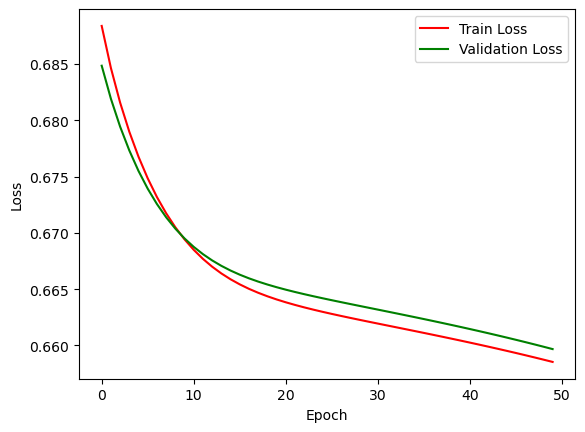

In [ ]:
# Plot loss function for train and validation
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss', color='red')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])


## Evaluate Model Performance

1. Evaluate the model on the testing dataset
2. Map the output probabilities to 0 or 1
3. Plot the distribution of scores, split by Signal and Background.
4. Compute various metrics
5. Plot ROC curve (example code given)

### Bonuses
1. Study the feature importance of your model

In [ ]:
y_pred = model(torch.tensor(X_test_scaled,dtype=torch.float32))

In [ ]:
y_pred

tensor([[0.6113],
        [0.7512],
        [0.8637],
        ...,
        [0.9226],
        [0.5694],
        [0.6248]], grad_fn=<SigmoidBackward0>)

In [ ]:
true_signal = y_pred[y_test==1].detach().numpy()
true_bkg = y_pred[y_test==0].detach().numpy()

Text(0, 0.5, 'Counts')

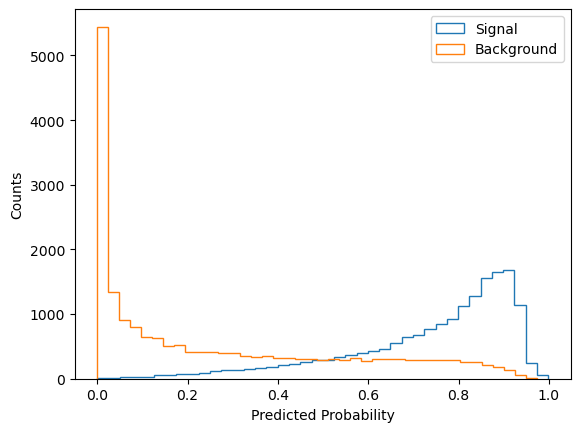

In [ ]:
plt.hist(true_signal, bins=40, histtype='step', label='Signal', density=False)
plt.hist(true_bkg, bins=40, histtype='step', label='Background', density=False)
plt.legend(["Signal","Background"])
plt.xlabel("Predicted Probability")
plt.ylabel("Counts")

In [ ]:
final_prediction_score =y_pred.detach().numpy()
final_prediction = np.round(final_prediction_score,0)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, final_prediction)
print(accuracy)


0.8114619697450545


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
precision = precision_score(y_test, final_prediction, average='weighted')
recall = recall_score(y_test, final_prediction, average='weighted')
f1 = f1_score(y_test, final_prediction, average='weighted')
roc_auc_score(y_test,final_prediction_score)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.7548865414499559
Recall: 0.7550513064635566
F1 Score: 0.7545421068215233


In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test,final_prediction_score)

0.828080674360504

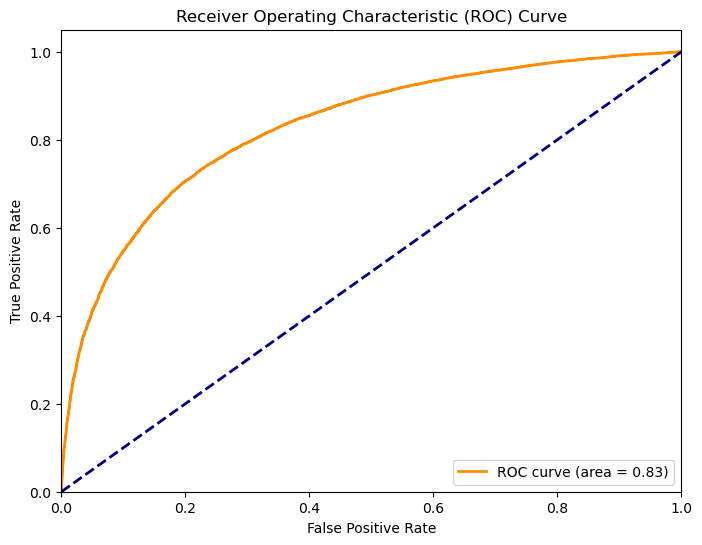

In [ ]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, final_prediction_score)

# Compute AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Compute feature importance of 26 input features to DNN
import numpy as np
from sklearn.metrics import accuracy_score

def permutation_importance(model, X_val_tensor, y_val):

    detach_to_binary = lambda x: np.round(model(x).detach().numpy())

    baseline_score = accuracy_score(y_val, detach_to_binary(X_val_tensor))  # For a classification task
    importances = []

    for feature_idx in range(X_val_tensor.shape[1]):
        # Shuffle the values of the current feature
        X_val_shuffled = X_val_tensor.clone()
        X_val_shuffled[:, feature_idx] = X_val_shuffled[:, feature_idx][torch.randperm(X_val.shape[0])]

        # Recalculate the performance
        score_shuffled = accuracy_score(y_val, detach_to_binary(X_val_shuffled))
        print(score_shuffled)

        # The difference in performance is the importance of this feature
        importances.append(baseline_score - score_shuffled)

    return np.array(importances)

# Usage example
importances = permutation_importance(model, X_val_tensor, y_val_tensor)


0.8001957050671744
0.8002750449592722
0.6870041256743891
0.7884534010367079
0.8112503966994605
0.8071247223103777
0.7270443245530519
0.8381466201205966
0.817147995345393
0.816301703163017
0.8399449910081456
0.8424838675552735
0.8513170422088226
0.8520575478684016
0.8517137416693114
0.8528773934200783
0.8408970697133186
0.6496879297577489
0.8468475616206496
0.8571881942240559


In [ ]:
idx = np.argsort(np.asarray(importances))

In [ ]:
df_background.columns.to_numpy()[:23]

array(['lepton0_px', 'lepton0_py', 'lepton0_pz', 'lepton0_energy',
       'lepton1_px', 'lepton1_py', 'lepton1_pz', 'lepton1_energy',
       'jet0_px', 'jet0_py', 'jet0_pz', 'jet0_energy', 'jet1_px',
       'jet1_py', 'jet1_pz', 'jet1_energy', 'Njets', 'HT_all',
       'MissingEnergy', 'lepton0_mass', 'lepton1_mass', 'jet0_mass',
       'jet1_mass'], dtype=object)

In [ ]:
sorted_features_descending = df_background.columns.to_numpy()[idx]

for i in range(len(sorted_features_descending)):
    print(f"Feature: {sorted_features_descending[i]}, Importance: {importances[idx[i]]:.4f}")

Feature: lepton0_mass, Importance: -0.0003
Feature: jet1_energy, Importance: 0.0040
Feature: jet1_py, Importance: 0.0048
Feature: jet1_pz, Importance: 0.0052
Feature: jet1_px, Importance: 0.0056
Feature: MissingEnergy, Importance: 0.0100
Feature: jet0_energy, Importance: 0.0144
Feature: Njets, Importance: 0.0160
Feature: jet0_pz, Importance: 0.0170
Feature: lepton1_energy, Importance: 0.0188
Feature: jet0_px, Importance: 0.0397
Feature: jet0_py, Importance: 0.0406
Feature: lepton1_px, Importance: 0.0456
Feature: lepton1_py, Importance: 0.0498
Feature: lepton0_py, Importance: 0.0566
Feature: lepton0_px, Importance: 0.0567
Feature: lepton0_energy, Importance: 0.0684
Feature: lepton1_pz, Importance: 0.1299
Feature: lepton0_pz, Importance: 0.1699
Feature: HT_all, Importance: 0.2072


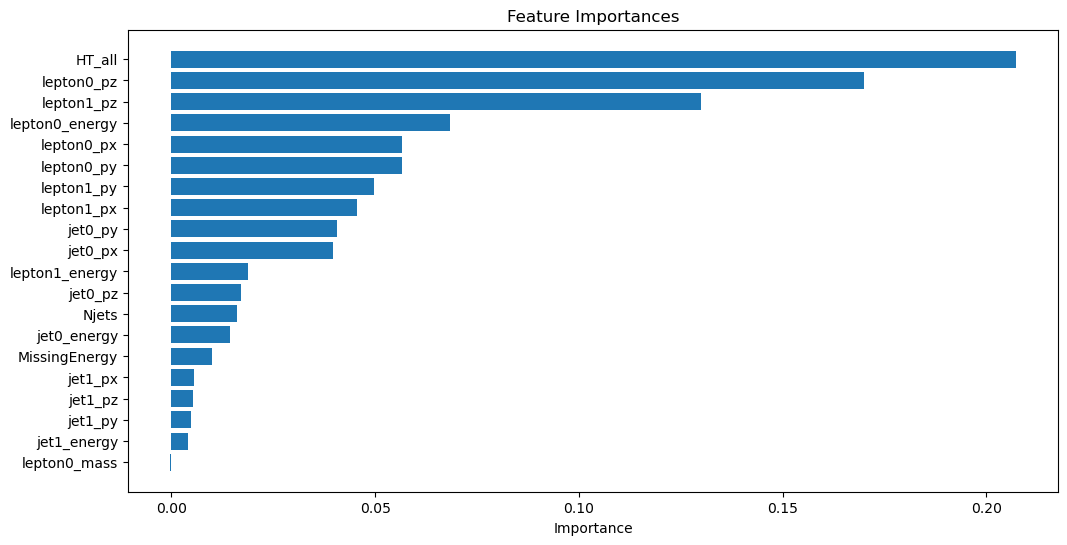

In [ ]:
# Plot feature importances
import matplotlib.pyplot as plt
importances = importances[idx]
plt.figure(figsize=(12, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), sorted_features_descending)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()